In [0]:
# comp4211 project

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import torch
import PIL
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from torchvision import transforms, utils, models
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from scipy import sparse

In [0]:
transform = transforms.Compose(
    [transforms.Resize(size = (512,512)),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

class imgDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform):
        df = pd.read_csv(csv_file)
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = self.root_dir+'/'+str(self.df.iloc[idx,0])+'.jpg'
        X = self.transform(PIL.Image.open(img_name).convert('RGB'))
        y = torch.tensor(self.df.iloc[idx,1:])
        return X, y

In [0]:
#initialize seed
torch.manual_seed(1)

#file path from my drive
train_data = imgDataset(csv_file = '/content/drive/My Drive/Colab/COMP4211 Project/train.csv', 
                       root_dir = "/content/drive/My Drive/Colab/COMP4211 Project/images/", transform = transform)

train_size = int(0.8 * len(train_data))
valid_size = len(train_data) - train_size

train, valid = random_split(train_data, [train_size, valid_size])

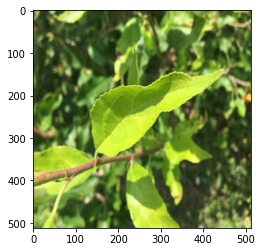

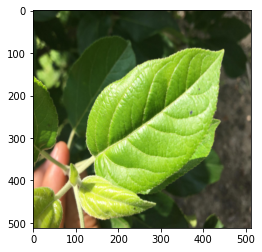

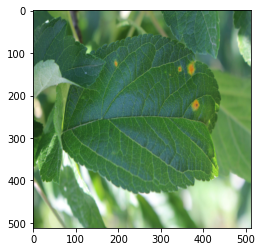

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.show()

imshow(train[0][0])
imshow(train[1][0])
imshow(train[10][0])

In [0]:
batch_size = 8

train_loader = DataLoader(train, batch_size=batch_size,
                          shuffle=True, num_workers=4)
valid_loader = DataLoader(valid, batch_size=batch_size,
                          shuffle=True, num_workers=4)

In [0]:
def train_model(model, criterion, optimizer, num_epochs, eval_every, device):
  global_step = 0
  total_step = len(train_loader) * num_epochs
  running_loss = 0.0
  train_losses = []
  val_losses = []

  for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("-------------------")

    for i, (inputs, labels) in enumerate(train_loader):
      inputs = inputs.to(device)
      labels = labels.to(device)

      #forward
      outputs = model(inputs)
      loss = criterion(outputs, labels.float())
      #backward
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      global_step += 1
      running_loss += loss.item()

      if global_step % eval_every == 0:
        with torch.no_grad():
          model.eval()
          val_running_loss = 0.0
          for j, (val_inputs, val_labels) in enumerate(valid_loader):
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels.float())
            val_running_loss += val_loss.item()

          avg_train_loss = running_loss / eval_every
          avg_val_loss = val_running_loss / len(valid_loader)

          train_losses.append(avg_train_loss)
          val_losses.append(avg_val_loss)

          print(f"Step: {global_step}/{total_step}, Avg train loss: {avg_train_loss:.4f}, Avg val loss: {avg_val_loss:.4f}")
          running_loss = 0.0
    
  print("Finished training")
  return train_losses, val_losses
          

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
num_filters = model.fc.in_features
model.fc = nn.Linear(num_filters, 4)

model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

train_losses, val_losses = train_model(model, criterion, optimizer, 5, 50, device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



Epoch 1/5
-------------------
Step: 50/910, Avg train loss: 0.4670, Avg val loss: 0.2705
Step: 100/910, Avg train loss: 0.2111, Avg val loss: 0.1345
Step: 150/910, Avg train loss: 0.1893, Avg val loss: 0.1281
Epoch 2/5
-------------------
Step: 200/910, Avg train loss: 0.1575, Avg val loss: 0.1595
Step: 250/910, Avg train loss: 0.1308, Avg val loss: 0.1395
Step: 300/910, Avg train loss: 0.0924, Avg val loss: 0.1205
Step: 350/910, Avg train loss: 0.0917, Avg val loss: 0.1281
Epoch 3/5
-------------------
Step: 400/910, Avg train loss: 0.0728, Avg val loss: 0.1187
Step: 450/910, Avg train loss: 0.0782, Avg val loss: 0.0982
Step: 500/910, Avg train loss: 0.0723, Avg val loss: 0.0917
Epoch 4/5
-------------------
Step: 550/910, Avg train loss: 0.1125, Avg val loss: 0.0992
Step: 600/910, Avg train loss: 0.0751, Avg val loss: 0.1027
Step: 650/910, Avg train loss: 0.0558, Avg val loss: 0.1016
Step: 700/910, Avg train loss: 0.0330, Avg val loss: 0.0889
Epoch 5/5
-------------------
Step: 750/

In [0]:
def eval(model, test_loader):
  y_pred = np.empty((0,4))
  y_label = np.empty((0,4))
  with torch.no_grad():
    for inputs, labels in test_loader:
      model.eval()
      inputs = inputs.to(device)
      outputs = model(inputs)
      y_pred = np.vstack((y_pred, nn.functional.softmax(outputs, dim=1).cpu().numpy()))
      y_label = np.vstack((y_label, labels.cpu().numpy()))
  print(roc_auc_score(y_label, y_pred, average='macro'))

In [11]:
eval(model, valid_loader)

0.9791428853611812


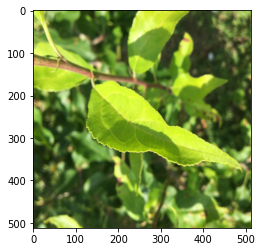

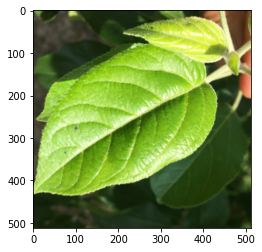

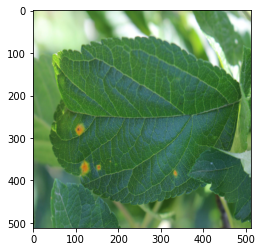

In [12]:
torch.manual_seed(1)

transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomVerticalFlip(p=0.5),
     transforms.ColorJitter(0.02,0.02,0.02,0.02),
     transforms.RandomResizedCrop(size = 512, scale = (0.6,1.0)),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train_data = imgDataset(csv_file = '/content/drive/My Drive/Colab/COMP4211 Project/train.csv', 
                       root_dir = "/content/drive/My Drive/Colab/COMP4211 Project/images/", transform = transform)

train_size = int(0.8 * len(train_data))
valid_size = len(train_data) - train_size

train, valid = random_split(train_data, [train_size, valid_size])

imshow(train[0][0])
imshow(train[1][0])
imshow(train[10][0])

In [13]:
batch_size = 8
train_loader = DataLoader(train, batch_size=batch_size,
                          shuffle=True, num_workers=4)
valid_loader = DataLoader(valid, batch_size=batch_size,
                          shuffle=True, num_workers=4)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
num_filters = model.fc.in_features
model.fc = nn.Linear(num_filters, 4)

model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

train_losses2, val_losses2 = train_model(model, criterion, optimizer, 5, 50, device)

Epoch 1/5
-------------------
Step: 50/910, Avg train loss: 0.4644, Avg val loss: 0.2770
Step: 100/910, Avg train loss: 0.2040, Avg val loss: 0.1553
Step: 150/910, Avg train loss: 0.1933, Avg val loss: 0.1237
Epoch 2/5
-------------------
Step: 200/910, Avg train loss: 0.1644, Avg val loss: 0.1444
Step: 250/910, Avg train loss: 0.1320, Avg val loss: 0.1105
Step: 300/910, Avg train loss: 0.0971, Avg val loss: 0.1596
Step: 350/910, Avg train loss: 0.1366, Avg val loss: 0.1451
Epoch 3/5
-------------------
Step: 400/910, Avg train loss: 0.0949, Avg val loss: 0.1158
Step: 450/910, Avg train loss: 0.1027, Avg val loss: 0.0943
Step: 500/910, Avg train loss: 0.1001, Avg val loss: 0.0989
Epoch 4/5
-------------------
Step: 550/910, Avg train loss: 0.1291, Avg val loss: 0.0918
Step: 600/910, Avg train loss: 0.1241, Avg val loss: 0.1164
Step: 650/910, Avg train loss: 0.1089, Avg val loss: 0.1158
Step: 700/910, Avg train loss: 0.0856, Avg val loss: 0.0908
Epoch 5/5
-------------------
Step: 750/9

In [14]:
eval(model, valid_loader)

0.9820771459012889


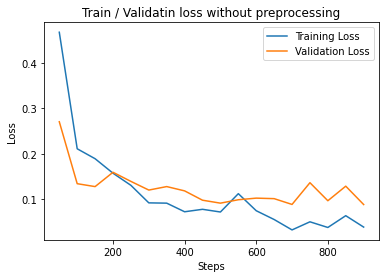

In [29]:
plt.plot(np.arange(50,910,50),train_losses, label="Training Loss")
plt.plot(np.arange(50,910,50),val_losses, label="Validation Loss")
plt.legend()
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Train / Validatin loss without preprocessing")
plt.show()

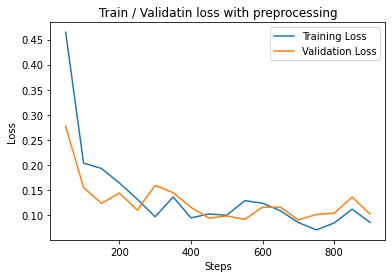

In [30]:
plt.plot(np.arange(50,910,50),train_losses2, label="Training Loss")
plt.plot(np.arange(50,910,50),val_losses2, label="Validation Loss")
plt.legend()
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Train / Validatin loss with preprocessing")
plt.show()